In [1]:
# !pip install interpret
# !pip install --user xgboost
# !pip install pytorch-tabnet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from interpret import preserve, show
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

random_state=42

In [3]:
dataset_folder = 'dataset/ESDRPD/'

file = 'Dataset 2 _ Early-stage diabetes risk prediction dataset (ESDRPD).xlsx'
class_names = [0, 1]
_class = 'Class'

In [4]:
df = pd.read_excel(open(dataset_folder + file, 'rb'), sheet_name='Dataset 2 – Early-stage diabete')
 
df.replace(('Yes', 'No'), (1, 0), inplace=True)
df.replace(('Positive', 'Negative'), (1, 0), inplace=True)
df.replace(('Male', 'Female'), (1, 0), inplace=True)
df.head()

Age  Gender  Polyuria  Polydipsia  Sudden weight loss  Weakness  \
0   40       1         0           1                   0         1   
1   58       1         0           0                   0         1   
2   41       1         1           0                   0         1   
3   45       1         0           0                   1         1   
4   60       1         1           1                   1         1   

   Polyphagia  Genital thrush  Visual blurring  Itching  Irritability  \
0           0               0                0        1             0   
1           0               0                1        0             0   
2           1               0                0        1             0   
3           1               1                0        1             0   
4           1               0                1        1             1   

   Delayed healing  Partial paresis  Muscle stiffness  Alopecia  Obesity  \
0                1                0                 1         1        1   
1                0                1                 0         1        0   
2                1                0                 1         1        0   
3                1                0                 0         0        0   
4                1                1                 1         1        1   

   Class  
0      1  
1      1  
2      1  
3      1  
4      1

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Age                 520 non-null    int64
 1   Gender              520 non-null    int64
 2   Polyuria            520 non-null    int64
 3   Polydipsia          520 non-null    int64
 4   Sudden weight loss  520 non-null    int64
 5   Weakness            520 non-null    int64
 6   Polyphagia          520 non-null    int64
 7   Genital thrush      520 non-null    int64
 8   Visual blurring     520 non-null    int64
 9   Itching             520 non-null    int64
 10  Irritability        520 non-null    int64
 11  Delayed healing     520 non-null    int64
 12  Partial paresis     520 non-null    int64
 13  Muscle stiffness    520 non-null    int64
 14  Alopecia            520 non-null    int64
 15  Obesity             520 non-null    int64
 16  Class               520 non-null    int64
dt

In [6]:
X, y = df.drop(columns=[_class]), df[_class]

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random_state)

In [8]:
x_test.shape

(156, 16)

# EDA

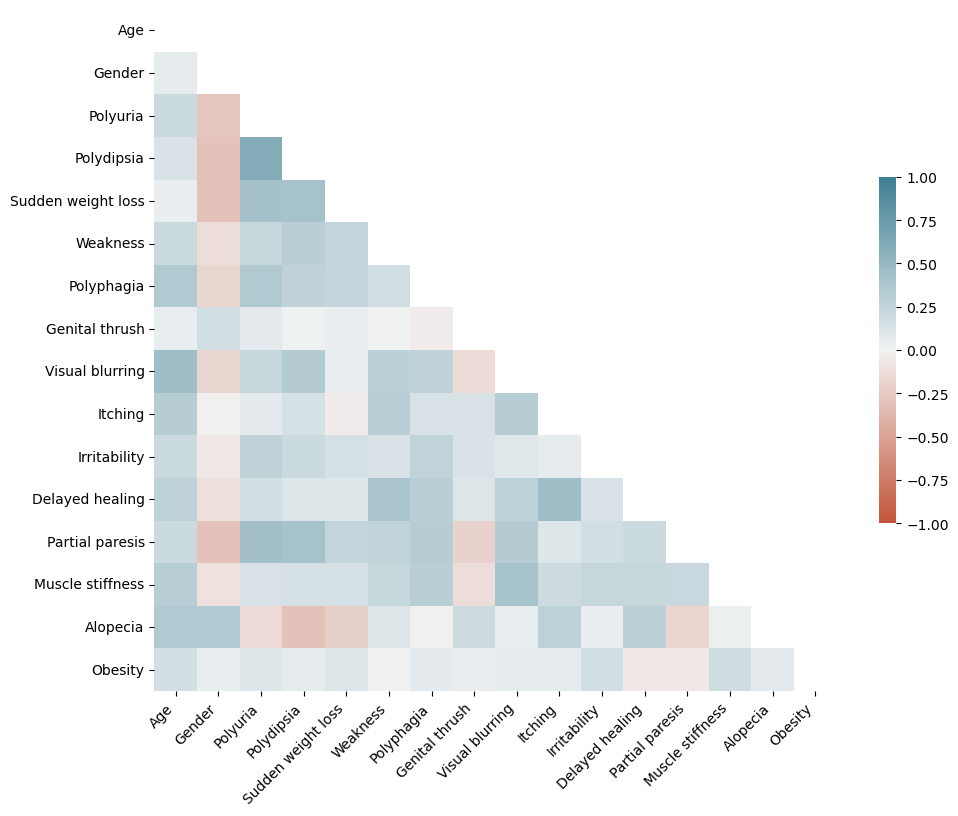

In [9]:
data = x_train
corr = data.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(
    corr, mask=mask,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,  cbar_kws={"shrink": .5}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [10]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 225 to 102
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Age                 364 non-null    int64
 1   Gender              364 non-null    int64
 2   Polyuria            364 non-null    int64
 3   Polydipsia          364 non-null    int64
 4   Sudden weight loss  364 non-null    int64
 5   Weakness            364 non-null    int64
 6   Polyphagia          364 non-null    int64
 7   Genital thrush      364 non-null    int64
 8   Visual blurring     364 non-null    int64
 9   Itching             364 non-null    int64
 10  Irritability        364 non-null    int64
 11  Delayed healing     364 non-null    int64
 12  Partial paresis     364 non-null    int64
 13  Muscle stiffness    364 non-null    int64
 14  Alopecia            364 non-null    int64
 15  Obesity             364 non-null    int64
dtypes: int64(16)
memory usage: 48.3 KB


# ML Model

In [11]:
import sklearn.metrics
import pandas as pd
import time
import numpy as np

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from interpret.glassbox import ExplainableBoostingClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

In [13]:
random_state=42

In [14]:
x_train

Age  Gender  Polyuria  Polydipsia  Sudden weight loss  Weakness  \
225   29       1         0           0                   0         1   
94    36       0         1           1                   0         1   
462   57       1         0           0                   0         0   
284   72       1         1           0                   0         0   
23    48       1         0           1                   1         1   
..   ...     ...       ...         ...                 ...       ...   
71    35       0         0           1                   1         1   
106   58       1         0           1                   1         1   
270   40       0         1           1                   1         1   
435   57       1         1           1                   1         1   
102   90       0         0           1                   1         0   

     Polyphagia  Genital thrush  Visual blurring  Itching  Irritability  \
225           0               0                0        0             0   
94            1               0                1        1             0   
462           1               0                1        0             0   
284           1               0                1        1             0   
23            0               0                1        1             1   
..          ...             ...              ...      ...           ...   
71            0               0                0        1             0   
106           1               0                1        1             0   
270           0               0                1        0             0   
435           1               0                1        0             0   
102           0               1                1        1             0   

     Delayed healing  Partial paresis  Muscle stiffness  Alopecia  Obesity  
225                0                0                 0         0        0  
94                 1                1                 0         0        0  
462                0                0                 1         0        0  
284                1                1                 1         1        0  
23                 1                0                 0         0        0  
..               ...              ...               ...       ...      ...  
71                 1                1                 1         0        0  
106                0                1                 0         1        1  
270                1                1                 1         0        0  
435                0                1                 0         0        0  
102                0                0                 1         1        0  

[364 rows x 16 columns]

In [15]:
def classify_report(clfs, dataset):
    x_train, y_train, x_test, y_test = dataset
    data = []
    for clf, name, no_df in clfs:
        if no_df:
            x_tr, x_te = x_train, x_test
        else:
            x_tr, x_te = x_train.values,  x_test.values
        clf.fit(x_tr, y_train)
        pred = clf.predict(x_te)
        f1, acc = sklearn.metrics.f1_score(y_test, pred, average='binary'), sklearn.metrics.accuracy_score(y_test, pred)
        data.append([name, f1, acc])
    df = pd.DataFrame(data, columns = ['Name', 'F1', 'Acc.'])
    df = df.sort_values(by=['F1'])
    return df

In [16]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [15, 25, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 15, 20],
    'min_samples_leaf': [1, 4, 8],
    'bootstrap': [False]
}

# Initialize the GridSearchCV with training data only
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Print the best parameters and best score from training data
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Training Score: {grid_search.best_score_}")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Training Score: 0.9698630136986301


In [17]:
from sklearn.metrics import accuracy_score
# Evaluate the best model on the test data
# best_rf = grid_search.best_estimator_
best_rf = RandomForestClassifier(**grid_search.best_params_, random_state=random_state)
best_rf.fit(x_train, y_train)
y_pred = best_rf.predict(x_test)
# Calculate accuracy on test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy}")

Test Set Accuracy: 0.9935897435897436


In [18]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=random_state)
gbc = GradientBoostingClassifier(random_state=random_state)
_xgb = xgb.XGBClassifier(random_state=random_state)
ebm = ExplainableBoostingClassifier(random_state=random_state)
tbn = TabNetClassifier(verbose=0, seed=random_state)

clfs = [(rf, 'rf', True), (gbc, 'gbc', True), (_xgb, 'xgb', True), (ebm, 'ebm', True), (tbn, 'tbn', False)]
# clfs = [(rf, 'rf', True), (ebm, 'ebm', True), (tbn, 'tbn', False)]
dataset = x_train, y_train, x_test, y_test
classify_report(clfs, dataset)

Name        F1      Acc.
4  tbn  0.175439  0.397436
3  ebm  0.980392  0.974359
2  xgb  0.985075  0.980769
1  gbc  0.990099  0.987179
0   rf  0.995074  0.993590

# XAI

In [19]:
# selected_model = _xgb
# For fairness of comparisions we used RF
selected_model = rf

In [20]:
import time, datetime
from joblib import Parallel, delayed
import itertools

n_jobs = 8

In [21]:
class_names = ['NO','YES']
feature_names = x_train.columns.to_list()
# local = lime, shap, anchor, tabnet, ebm
# global = pfi, tabnet, ebm, shap
# methods = pfi, tabnet, ebm, shap, lime, anchor
# remaining = pdp, eli5, ice, adawhip, break down

## Local

### LIME

In [22]:
import lime
from lime import lime_tabular

In [23]:
exp_lime=lime_tabular.LimeTabularExplainer(np.array(x_train),feature_names=x_train.columns,class_names=['NO','YES'],mode='classification')

In [24]:

def lime_explain_instance_step(i, lim):
    warnings.filterwarnings("ignore")
    out = []
    for k in range(i, lim):
        e = exp_lime.explain_instance(x_test.values[k], selected_model.predict_proba)
        out.append(e)
    return out

# lime_explanations_list = [exp_lime.explain_instance(x_test.values[i], selected_model.predict_proba) for i in range(len(x_test))]  # sequential and slower
total = len(x_test)
out = Parallel(n_jobs=n_jobs)(delayed(lime_explain_instance_step)(i, min(total, i+int(total/n_jobs))) for i in range(0, total, int(total/n_jobs)))
lime_explanations_list = list(itertools.chain(*out))


In [25]:
display(x_test.iloc[7:9])
display(y_test.iloc[7:9])

Age  Gender  Polyuria  Polydipsia  Sudden weight loss  Weakness  \
228   45       1         0           0                   0         1   
192   64       1         0           1                   0         0   

     Polyphagia  Genital thrush  Visual blurring  Itching  Irritability  \
228           0               0                0        1             1   
192           0               0                0        0             1   

     Delayed healing  Partial paresis  Muscle stiffness  Alopecia  Obesity  
228                1                1                 0         0        0  
192                1                0                 0         0        0

228    0
192    1
Name: Class, dtype: int64

In [26]:
id_to_explain = 7
lime_explanations_list[id_to_explain].show_in_notebook(show_table=True)

In [27]:
id_to_explain = 8
lime_explanations_list[id_to_explain].show_in_notebook(show_table=True)

### SHAP

In [28]:
import shap
shap.plots.initjs()

In [29]:
exp_shap = shap.TreeExplainer(selected_model)
shap_values = exp_shap.shap_values(x_test)

In [30]:
# shap.force_plot(exp_shap.expected_value, shap_values[id_to_explain], x_test.iloc[id_to_explain])
shap.force_plot(exp_shap.expected_value[0], shap_values[id_to_explain][:,0], x_test.iloc[id_to_explain])

In [31]:
exp_shap_values = exp_shap(x_test)

In [32]:
# print(exp_shap.expected_value + sum(shap_values[3]))
print(exp_shap.expected_value[0] + sum(shap_values[3][:, 0]))
print(selected_model.predict_proba(x_test)[3, 0])

0.05999999999999989
0.06


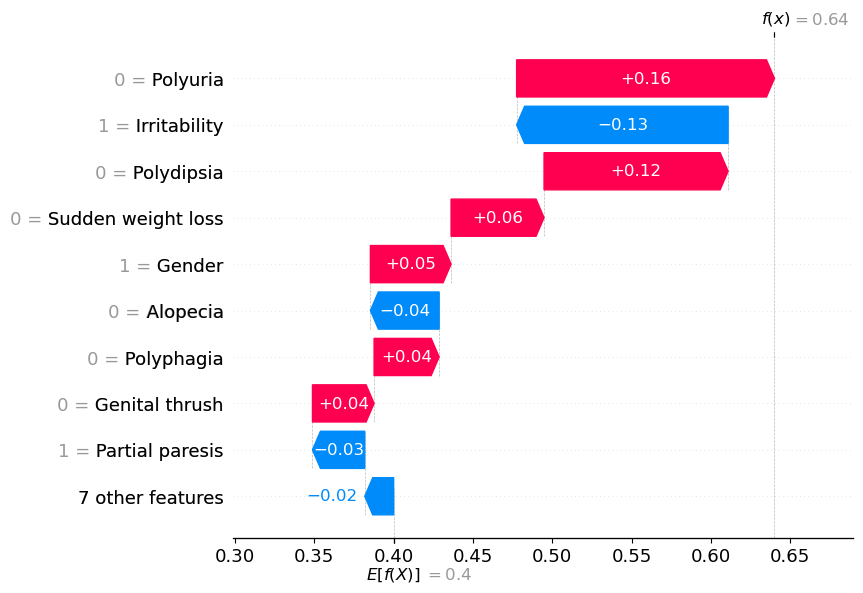

In [33]:
id_to_explain = 7
output_to_explain = 0

# shap.plots.waterfall(exp_shap_values[id_to_explain], max_display=10)
shap.plots.waterfall(exp_shap_values[id_to_explain,:,output_to_explain], max_display=10)

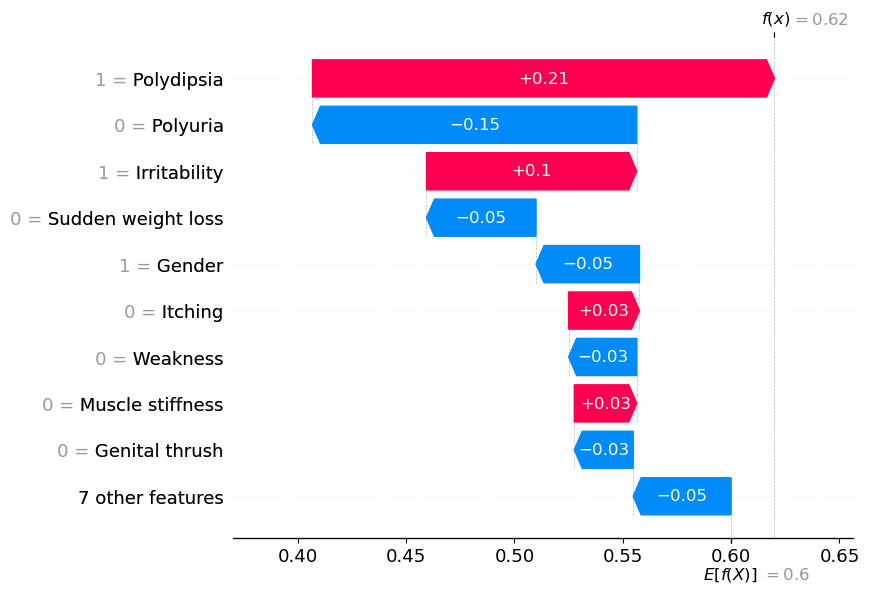

In [34]:
id_to_explain = 8
output_to_explain = 1
# shap.plots.waterfall(exp_shap_values[id_to_explain], max_display=10)
shap.plots.waterfall(exp_shap_values[id_to_explain,:,output_to_explain], max_display=10)

#### Fidelity

In [35]:
selected_model_predict_proba_array = selected_model.predict_proba(x_test)
selected_model_predict_array = selected_model.predict(x_test)

In [114]:
id_to_test = 7
print('LIME', selected_model_predict_proba_array[id_to_test, 1], lime_explanations_list[id_to_test].local_pred[0])
print(int(lime_explanations_list[id_to_test].local_pred[0]>0.5))
print('SHAP', selected_model_predict_proba_array[id_to_test, 1], exp_shap.expected_value[1] + np.sum(shap_values[id_to_test][:, 1]))
print(int(exp_shap.expected_value[1] + np.sum(shap_values[id_to_test][:, 1])>0.5))
del id_to_test

LIME 0.36 0.4412063739990778
0
SHAP 0.36 0.3599999999999998
0


In [122]:
lime_fidelity = np.mean([1-np.abs(selected_model_predict_proba_array[i, 1] - (lime_explanations_list[i].local_pred[0])) for i in range(len(x_test))])
print(f'LIME Fidelity: {lime_fidelity:.4f}')

# For SHAP, fidelity is usually high as it's designed to be an accurate representation of the model
shap_fidelity = np.mean([1-np.abs(selected_model_predict_proba_array[i, 1] - (exp_shap.expected_value[1] + np.sum(shap_values[i][:, 1]))) for i in range(len(x_test))])
print(f'SHAP Fidelity: {shap_fidelity:.4f}')

LIME Fidelity: 0.7889
SHAP Fidelity: 1.0000


In [118]:
# accuracy_score(selected_model.predict(X_test), np.argmax(shap_values, axis=1))
from sklearn.metrics import accuracy_score

lime_predict_array = np.array([int(lime_explanations_list[i].local_pred[0]>0.5) for i in range(len(x_test))])
shap_predict_array = np.array([int(exp_shap.expected_value[1] + np.sum(shap_values[i][:, 1])>0.5) for i in range(len(x_test))])

print(f'LIME Fidelity (Predict): {accuracy_score(selected_model_predict_array, lime_predict_array):.4f}')
print(f'SHAP Fidelity (Predict): {accuracy_score(selected_model_predict_array, shap_predict_array):.4f}')

LIME Fidelity (Predict): 0.9167
SHAP Fidelity (Predict): 1.0000


In [119]:
differing_indices = np.where(selected_model_predict_array != shap_predict_array)[0]
differing_indices

array([], dtype=int64)

In [121]:
for id_to_test in differing_indices:
    print('LIME', selected_model_predict_proba_array[id_to_test, 1], lime_explanations_list[id_to_test].local_pred[0])
    print(int(lime_explanations_list[id_to_test].local_pred[0]>0.5))
    print('SHAP', selected_model_predict_proba_array[id_to_test, 1], exp_shap.expected_value[1] + np.sum(shap_values[id_to_test][:, 1]))
    print(int(exp_shap.expected_value[1] + np.sum(shap_values[id_to_test][:, 1])>0.5))

In [36]:
# lime_fidelity = np.mean([np.abs(selected_model_predict_proba_array[i, 0] - (lime_explanations_list[i].local_pred[0])) for i in range(len(x_test))])
# print(f'LIME Fidelity: {lime_fidelity:.2f}')

# # For SHAP, fidelity is usually high as it's designed to be an accurate representation of the model
# shap_fidelity = np.mean([np.abs(selected_model_predict_proba_array[i, 1] - (exp_shap.expected_value[0] + np.sum(shap_values[i][:, 0]))) for i in range(len(x_test))])
# print(f'SHAP Fidelity: {shap_fidelity:.2f}')

LIME Fidelity: 0.73
SHAP Fidelity: 0.87


In [37]:
# # accuracy_score(selected_model.predict(X_test), np.argmax(shap_values, axis=1))
# from sklearn.metrics import accuracy_score

# lime_predict_array = np.array([1 if lime_explanations_list[i].local_pred[0]>0.5 else 0 for i in range(len(x_test))])
# shap_predict_array = np.array([0 if exp_shap.expected_value[0] + np.sum(shap_values[i][:, 0])>exp_shap.expected_value[0] + np.sum(shap_values[i][:, 1]) else 1 for i in range(len(x_test))])

# print(f'LIME Fidelity (Predict): {accuracy_score(selected_model_predict_array, lime_predict_array):.4f}')
# print(f'SHAP Fidelity (Predict): {accuracy_score(selected_model_predict_array, shap_predict_array):.4f}')

LIME Fidelity (Predict): 0.9295
SHAP Fidelity (Predict): 0.9936


### EBM

In [38]:
ebm_local = ebm.explain_local(x_test, y_test, name='EBM')

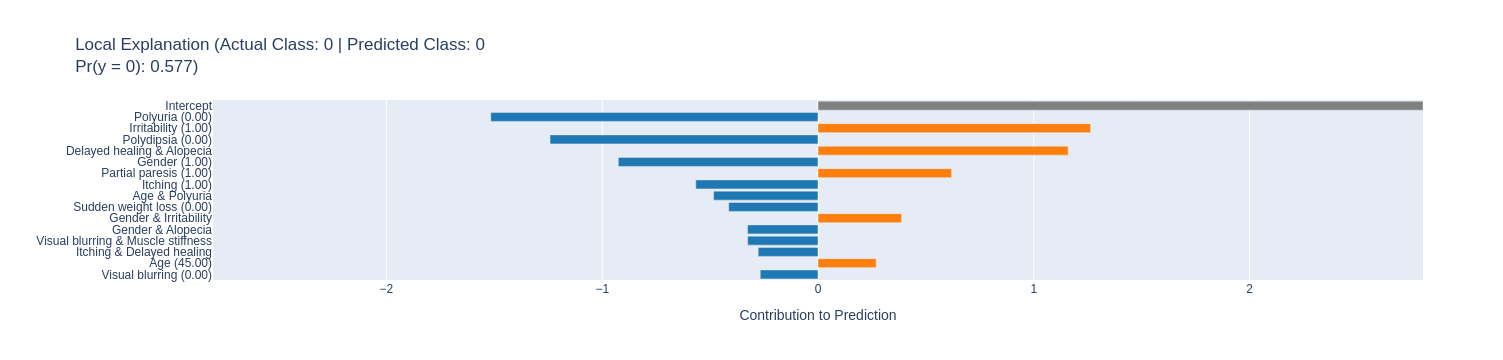

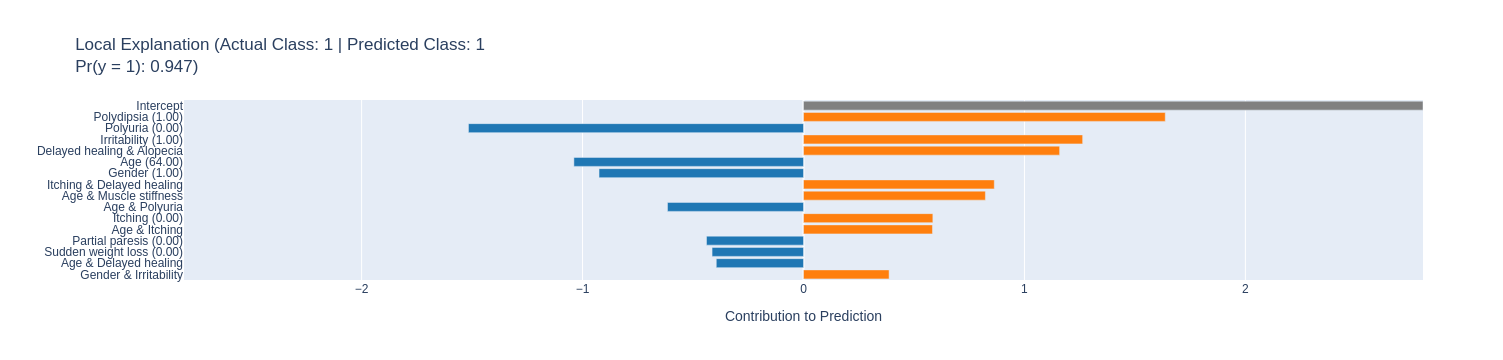

In [39]:
# show(ebm.explain_local(x_test[554:555+1], y_test[554:555+1]), 0)
preserve(ebm_local, 7)
preserve(ebm_local, 8)

### TABNET

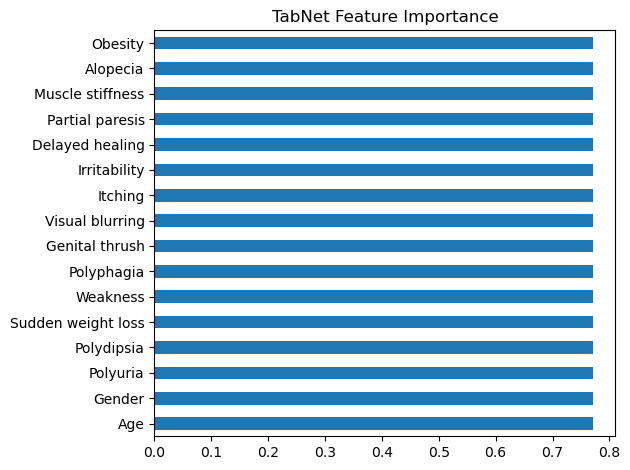

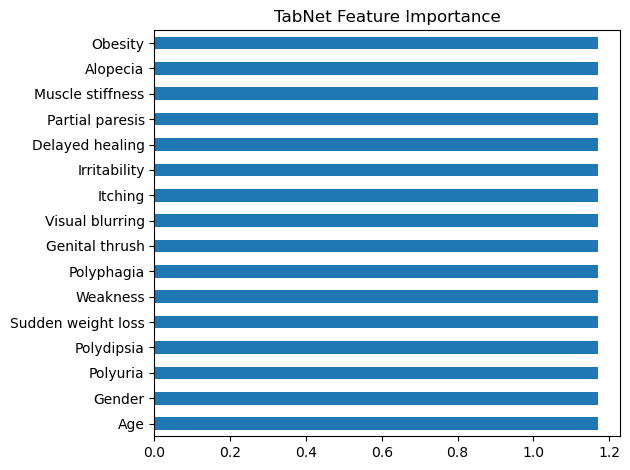

In [40]:
explain_tabnet_matrix, tabnet_masks = tbn.explain(x_test.values)

def get_tbn_local_graph(idx, feature_names):
    m = explain_tabnet_matrix[idx]>0
    ax = pd.Series(explain_tabnet_matrix[idx][m], index=np.array(feature_names)[m]).sort_values(ascending=True).plot.barh()
    ax.set_title("TabNet Feature Importance")
    ax.figure.tight_layout()
    plt.show()

get_tbn_local_graph(7, feature_names)
get_tbn_local_graph(8, feature_names)

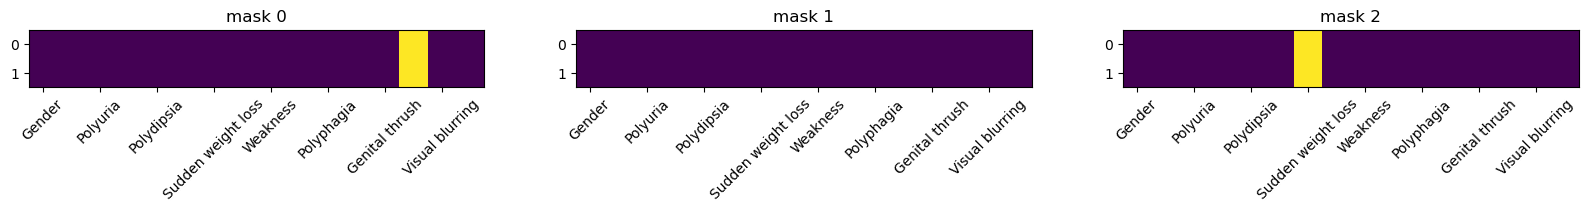

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))


for i in range(3):
    axs[i].imshow(tabnet_masks[i][7:9])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticklabels(labels = feature_names, rotation=45)

#### Simplicity

In [42]:
# https://link.springer.com/chapter/10.1007/978-3-031-20319-0_30
# Simplicity is the ability to choose only the necessary and sufficient features for explaining the prediction.

# Calculate simplicity
def calculate_simplicity(_values, threshold=0.05):
    simplicity_scores = []
    for instance_value in _values:
        abs_values = np.abs(instance_value)
        num_important_features = np.sum( abs_values > (max(abs_values) *threshold))
        simplicity_scores.append(num_important_features)
    return np.mean(simplicity_scores)


def get_simplicity_dict(name, values, threshold_list=[0.1, 0.05, 0.01]):
    d = {'Method': name}
    for threshold in threshold_list:
        d[threshold] = calculate_simplicity(values, threshold)
    return d

lime_feature_values = [list(zip(*lime_explanations_list[i].as_list()))[1] for i in range(len(x_test))]
ebm_local_scroes = [ebm_local.data(i)['scores'] for i in range(len(x_test))]

list_of_scores_dict = [get_simplicity_dict(name, values) for name, values in 
                       [('LIME', lime_feature_values), ('SHAP', shap_values[:,:,0]), ('EBM', ebm_local_scroes),
                        ('TABNET', explain_tabnet_matrix)]]

_df_simplicity = pd.DataFrame(list_of_scores_dict)
_df_simplicity.set_index('Method', inplace=True)
_df_simplicity


0.1       0.05       0.01
Method                                 
LIME     9.820513  10.000000  10.000000
SHAP     8.929487  12.282051  15.371795
EBM     20.525641  27.737179  30.621795
TABNET  11.532051  12.326923  13.487179

In [43]:
# Common Top Feature Agreement

def retain_top_features(features, n=5):
    arr = np.abs(features)
    # Get the indices of the top n maximum values
    indices = np.argpartition(arr, -n)[-n:]

    # Create a mask
    mask = np.zeros_like(arr, dtype=bool)
    mask[indices] = True
    return np.where(mask, features, 0)

# lime_explanations_list[554].show_in_notebook(show_table=True)
# shap.plots.waterfall(exp_shap_values[554,:,output_to_explain], max_display=3)
def get_lime_feature_importance(lime_exp):
    feature_importance = {}
    for feature, sc in lime_exp.as_list():
        # print(feature)
        # Split feature by '<', '>', or '=' and take the first part as the feature name
        if feature.find('< ')>-1:
            feature = feature.split(' < ')[1]
        feature = feature.split(' > ')[0].strip()
        feature = feature.split(' <= ')[0].strip()
        for f in ['>', '<', '=']:
            if feature.find(f)>-1:
                print('error', feature)
        feature_importance[feature] = sc
    # print(feature_importance)
    # print([feature_importance.get(feature, 0) for feature in feature_names])
    return np.array([feature_importance.get(feature, 0) for feature in feature_names])

# lime_weights = dict(lime_explanations_list[0].as_list())
# lime_weights.get('Number_of_ANC_Visits', 0)
# pd.DataFrame([(shap_values[i][:, 0][1], get_lime_feature_importance(lime_explanations_list[i])[1]) for i in range(20)]).corr()
print(feature_names)

np.nonzero(retain_top_features(shap_values[2][:, 1], 2))[0], np.nonzero(retain_top_features(get_lime_feature_importance(lime_explanations_list[2]), 2))[0]

['Age', 'Gender', 'Polyuria', 'Polydipsia', 'Sudden weight loss', 'Weakness', 'Polyphagia', 'Genital thrush', 'Visual blurring', 'Itching', 'Irritability', 'Delayed healing', 'Partial paresis', 'Muscle stiffness', 'Alopecia', 'Obesity']


(array([2, 3]), array([2, 3]))

In [44]:
import numpy as np
from scipy.stats import ttest_rel, wilcoxon
from scipy.stats import shapiro

shap_val = lambda x, top_n=2: retain_top_features(shap_values[x][:, 1], top_n)
lime_val = lambda x, top_n=2: retain_top_features(get_lime_feature_importance(lime_explanations_list[x]), top_n)

def check_significant_differnce(dist1, dist2, top_n=2):
    data_process_1 = dist1
    data_process_2 = dist2
    
    # Shapiro-Wilk test
    # Shapiro-Wilk Test: If the p-value is less than 0.05, the null hypothesis that the data is normally distributed is rejected.
    for data in [data_process_1, data_process_2]:
        stat, p_value = shapiro(data)
        if not p_value<0.05:
            print('Alert: Normally distributed')
            print(f'Shapiro-Wilk test: Statistics={stat}, p-value={p_value}')
    
    
    # A suitable test in this context would be the paired t-test if the data is normally distributed or the Wilcoxon signed-rank test if the data is not normally distributed.
    # Paired t-test
    # t_statistic, p_value_ttest = ttest_rel(data_process_1, data_process_2)
    # print(f"Paired t-test: t-statistic = {t_statistic}, p-value = {p_value_ttest}")
    
    # Wilcoxon signed-rank test
    w_statistic, p_value_wilcoxon = wilcoxon(data_process_1, data_process_2)
    # print(f"Wilcoxon signed-rank test: w-statistic = {w_statistic}, p-value = {p_value_wilcoxon}")
    if p_value_wilcoxon<0.05:
        print('Alert: significant difference')
    
    # If the p-value is less than the chosen significance level (e.g., 0.05), you reject the null hypothesis and conclude that there is a significant difference between the means of the two processes.
    return p_value_wilcoxon

lime_shap_diff_p = [ check_significant_differnce(lime_val(i, top_n=2), shap_val(i, top_n=2), ) for i in range(len(x_test))]

#### Consistency

In [45]:
# Consistency measures how similar the explanations produced by different XAI methods are when applied to the same input data

shap_val = lambda x, top_n=2: retain_top_features(shap_values[x][:, 1], top_n)
lime_val = lambda x, top_n=2: retain_top_features(get_lime_feature_importance(lime_explanations_list[x]), top_n)
tabnet_val = lambda x, top_n=2: retain_top_features(explain_tabnet_matrix[x], top_n)
from scipy.stats import spearmanr

def get_consistency(method1, method2):
    numerator = 0
    divider = 0
    avg_sp_corr_list = []
    for n in range(1, 6): #only top 5 features: 1 feature is counted 5 five times, 2 four times,.. 5th only one time.
        
        # Compute Spearman's rank correlation coefficient
        spearman_corr_array = np.array([spearmanr(method1(i, top_n=n), method2(i, top_n=n))[0] for i in range(len(x_test))])
        avg_spearman_corr = spearman_corr_array.mean()
        avg_sp_corr_list.append(avg_spearman_corr)
    
    return np.array(avg_sp_corr_list).mean()

print(f'LIME, SHAP Consistency: {get_consistency(lime_val, shap_val):.2f}')
print(f'LIME, TABNET Consistency: {get_consistency(lime_val, tabnet_val):.2f}')
print(f'TABNET, SHAP Consistency: {get_consistency(tabnet_val, shap_val):.2f}')

LIME, SHAP Consistency: 0.84
LIME, TABNET Consistency: -0.02
TABNET, SHAP Consistency: -0.03


#### Robustness

In [46]:
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

x_test_noisy = add_noise(x_test)
display(x_test_noisy)

lime_explanations_list_noisy = [exp_lime.explain_instance(x_test_noisy.values[i], selected_model.predict_proba) for i in range(len(x_test))]
shap_values_noisy = exp_shap.shap_values(x_test_noisy)
ebm_local_noisy = ebm.explain_local(x_test_noisy, y_test, name='EBM')
explain_tabnet_matrix_noisy, tabnet_masks_noisy = tbn.explain(x_test_noisy.values)

Age    Gender  Polyuria  Polydipsia  Sudden weight loss  Weakness  \
275  71.986933  1.000740  0.997246    0.022356           -0.009427 -0.001604   
93   39.999685  0.002191  0.998828    0.982503            0.004317  0.985194   
6    57.016736  0.988946  0.981412    0.994388            0.013586  1.006421   
167  40.998956  0.998399  0.990746    1.006490            1.005393  0.987973   
90   44.991967 -0.010649  0.013895   -0.020728           -0.007590  0.016015   
..         ...       ...       ...         ...                 ...       ...   
24   58.000453  0.985536  1.002158    0.989995            0.996832  0.983421   
17   66.994707  0.992870  0.000237    1.022823           -0.003736  1.002259   
245  29.997186  1.000797  0.001848   -0.004214           -0.004049 -0.000258   
66   30.016516  0.005110  0.986240    0.990757           -0.019774 -0.003778   
229  47.004963  0.987571 -0.009858    0.003883            0.006455 -0.007191   

     Polyphagia  Genital thrush  Visual blurring   Itching  Irritability  \
275    0.997925       -0.006240         1.004981  0.993107     -0.004959   
93     1.014251        0.008169         0.003345  0.991581      0.003780   
6      0.998016        0.997501        -0.005157 -0.003548      0.005709   
167    1.009946        0.994809         0.996140  1.008655      1.003710   
90     0.997647       -0.013559         0.995166  0.993760     -0.009873   
..          ...             ...              ...       ...           ...   
24     1.006225       -0.001801         0.989354 -0.008189     -0.005617   
17     1.004217        0.012675         1.004006  0.007220      1.007607   
245    0.029450       -0.000558         0.008860  0.001350      0.001891   
66    -0.003136       -0.003641        -0.010932  1.002365      0.011575   
229    0.005981       -0.005006         0.007345  1.000608      0.007899   

     Delayed healing  Partial paresis  Muscle stiffness  Alopecia   Obesity  
275         0.996332         0.992080          1.019179  0.999390 -0.001413  
93         -0.003197         1.011530         -0.003270  0.019598  0.012172  
6           1.003551         0.998583         -0.006107 -0.005767 -0.000396  
167        -0.005518        -0.009069          0.000664  0.001614  1.001216  
90         -0.001292         1.003116         -0.019302 -0.017872  0.003051  
..               ...              ...               ...       ...       ...  
24          1.006825         0.984585          1.005224 -0.005922  1.001553  
17          0.994270         0.998321          1.009982  1.014215  0.987432  
245        -0.008338        -0.000688          0.005895 -0.008509  0.002971  
66          1.016830         0.993617          0.012116  0.021599 -0.001696  
229         1.009861        -0.001287          0.012287  1.010223  0.008505  

[156 rows x 16 columns]

In [47]:


# Function to calculate changes in explanations
def calculate_robustness(original, noisy):
    arr_org = np.array(original)
    arr_noisy = np.array(noisy)
    change_matrix = np.abs(arr_org - arr_noisy)
    divisor = max( [arr_org.max(), arr_noisy.max()] ) - min(  [arr_org.min(), arr_noisy.min()]  )  # max - min normalise
    return change_matrix.mean() / divisor  # divided in order to normalise between 0 to 1 (otherwise when the feature importance goes beyond 1 and under -1 such as in tabnet, ebm this won't normalise to 1)

def lime_robustness(original, noisy):
    means_list = []
    _max, _min = 0, 0
    for i in range(len(original)):
        d1, d2 = dict(original[i].as_list()), dict(noisy[i].as_list())
        # print(d1.keys())
        # print(d2.keys())
        v1, v2 = list(zip(*[[d1.get(f, 0), d2.get(f, 0)] for f in set(list(d1.keys())+list(d2.keys()))]))
        arr_org = np.array(v1)
        arr_noisy = np.array(v2)
        _max = max( [arr_org.max(), arr_noisy.max(), _max] )
        _min = min( [arr_org.min(), arr_noisy.min(), _min] )
        means_list.append(np.abs(arr_org - arr_noisy).mean())
    divisor = _max - _min
    return np.array(means_list).mean()/divisor # max - min normalise
        


print('Robustness')

print(f'LIME: {lime_robustness(lime_explanations_list, lime_explanations_list_noisy):.4f}')
print(f'SHAP: {calculate_robustness(shap_values, shap_values_noisy):.4f}')
_ebm_robustness = calculate_robustness([ebm_local.data(i)['scores'] for i in range(len(x_test))], [ebm_local_noisy.data(i)['scores'] for i in range(len(x_test))])
print(f'EBM: {_ebm_robustness:.4f}')
print(f'TABNET: {calculate_robustness(explain_tabnet_matrix, explain_tabnet_matrix_noisy):.4f}')


Robustness
LIME: 0.0690
SHAP: 0.0002
EBM: 0.0000
TABNET: 0.0191


## Global

### PMI

Elapsed time to compute the importances: 1.525 seconds


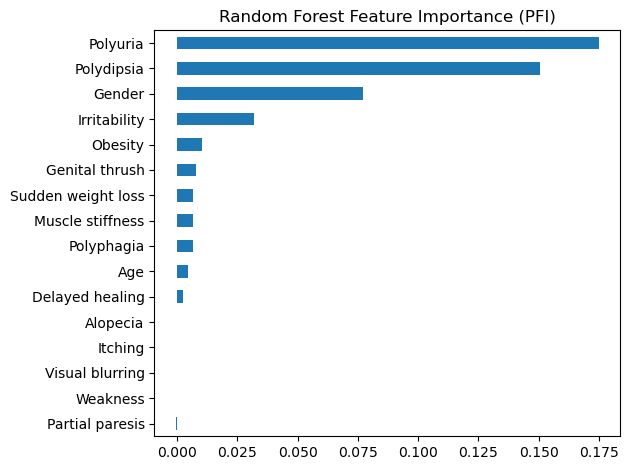

In [48]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    selected_model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

selected_model_importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=True)

ax = selected_model_importances.plot.barh()
ax.set_title("Random Forest Feature Importance (PFI)")
ax.figure.tight_layout()

### TABNET

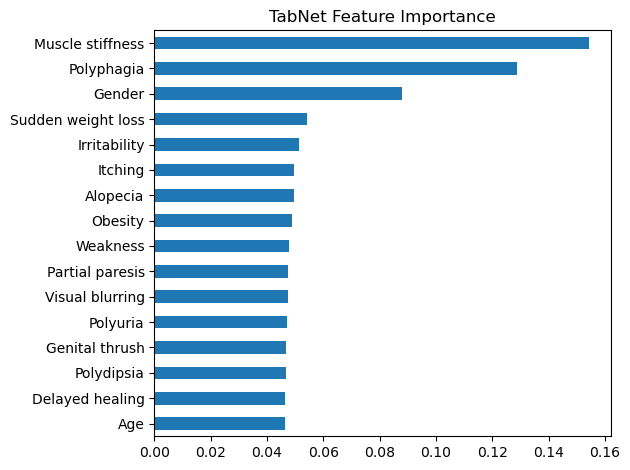

In [49]:
ax = pd.Series(tbn.feature_importances_, index=feature_names).sort_values(ascending=True).plot.barh()
ax.set_title("TabNet Feature Importance")
ax.figure.tight_layout()

### EBM

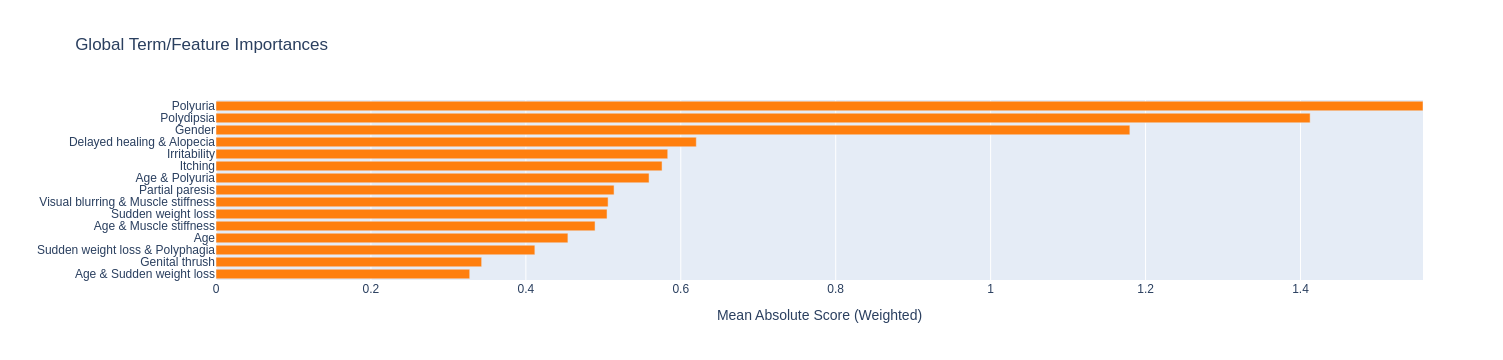

In [50]:
ebm_global = ebm.explain_global()
# show(ebm_global)

# Replace show with the preserve.

# ebm_global = ebm.explain_global(name='EBM')
# show(ebm_global)

# preserve(ebm_global, file_name='output/global-graph.html')
preserve(ebm_global)

### SHAP

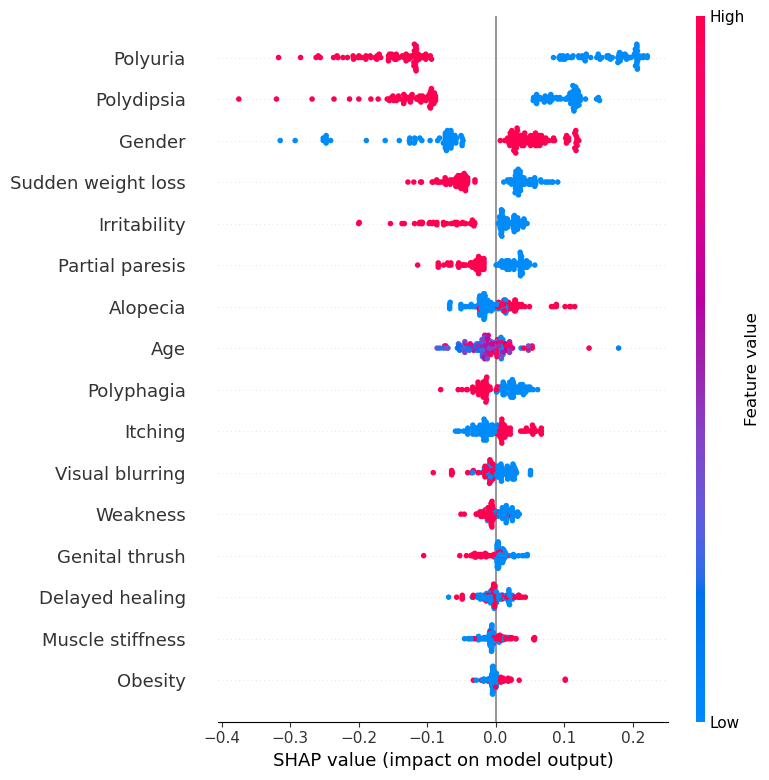

In [51]:
shap.summary_plot(shap_values[:,:,0], x_test)
# shap.summary_plot(shap_values[:,:,0], X_test)

In [52]:
# f.savefig("summary_plot_CS.png", bbox_inches='tight', dpi=600)